In [263]:
import pandas as pd
import numpy as np
from sklearn import manifold as sk
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

fp = "C:/Users/jacob/Desktop/Code/Python/Thesis App/Thesis_Web_App/Data/Audio Feature Data.csv"
data = pd.read_csv(fp)



In [264]:
## Data setup, leaving data untouched in case we want to prepare some fluff figures (key preference? etc.)
mode_minor = data['mode'] == "minor" 
mode_major = data['mode'] == "major"

numerical_data = data.drop(['id', 'name', 'key', 'camelot', 'duration', 'rating'], axis=1)
numerical_data.loc[mode_minor, 'mode'] = 0
numerical_data.loc[mode_major, 'mode'] = 1

## Loudness is measured in string format: "-16 dB", but we only care about the int.
for i in range(len(data)):
    loudness = numerical_data['loudness'][i]
    numerical_data.loc[i, 'loudness'] = int(loudness.split(' ')[0])


In [265]:
## Experimentimh with removing certain data
## Eventually combine these into one line.

## Removing mode:
numerical_data = numerical_data.drop(['mode'], axis=1)

## Removing loudness:
numerical_data = numerical_data.drop(['loudness'], axis=1)

In [266]:
## Computing dissimilarity matrix.

## First, scaling data to make each value represented equally in the data. 
## Necessary b/c some values vary much less than others, such as mode being 0 or 1.

scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

In [267]:
## Calculating distances -- this can be done in sklearn's MDS implementation automatically, but doing it separately lends a tad more control.
scaled = False ## Use if normalizing the data via the cell above.

if scaled:
    pairwise_distances = cdist(scaled_numerical_data, scaled_numerical_data)
else:
    pairwise_distances = cdist(numerical_data, numerical_data)

**Only Perform One of the Following: MDS or PCA**


In [268]:
## Perform MDS!
## n_components: number of dimensions to output.
## n_init: number of different initializations that are done
mds = sk.MDS(n_components=3, n_init=4, dissimilarity='precomputed', verbose=1)

MDS_data = np.asarray(mds.fit_transform(pairwise_distances))

Convergence criterion reached.
Convergence criterion reached.
Convergence criterion reached.


In [270]:
pca = PCA(n_components=3)
PCA_data = pca.fit_transform(scaled_numerical_data)
print(pca.explained_variance_ratio_.cumsum())

[0.27425147 0.42320558 0.55884687]


In [271]:
## Normalized stress calculations, thanks ChatGPT!

# Original pairwise distances
D_orig = pairwise_distances

# Distances in the embedding
D_embedded = cdist(MDS_data, MDS_data)

# Compute Kruskal’s Stress-1
stress_1 = np.sqrt(((D_orig - D_embedded) ** 2).sum() / (D_orig ** 2).sum())

print(f"Stress: {stress_1}")

Stress: 0.14688293963835544


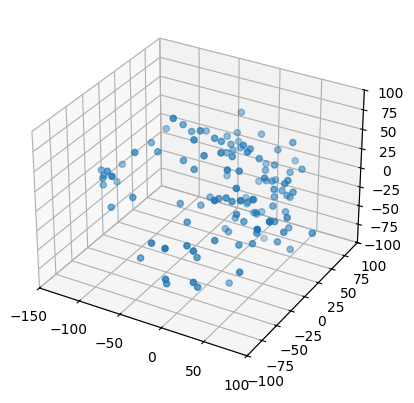

In [ ]:
## Post-processing dependent on rating:
split_by_rating = True
match_rating = False ## To look at only one rating group.
rating = 7

if scaled: ## Scaled is defined where pairwise_distances is calculated above.
    x_lim = [-6,6]
    y_lim = [-6,4]
    z_lim = [-6,4]
else:
    x_lim = [-150,100]
    y_lim = [-100,100]
    z_lim = [-100,100]

final_data = MDS_data ## Allows me to change rating values w/o deleting the entire array constantly.

if split_by_rating:
    if match_rating:
        unsuitable_entries = data['rating'] == rating
        indices = list(np.where(~unsuitable_entries)[0])
    else:
        unsuitable_entries = data['rating'] < rating
        indices = list(np.where(unsuitable_entries)[0])

    final_data = np.delete(final_data, indices, axis=0)

x,y,z = final_data[:, 0:1], final_data[:,1:2], final_data[:,2:3]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.set_zlim(z_lim[0], z_lim[1])
ax.scatter(x,y,z)
plt.show()